## GPP Contribution EDA
Goal: To determine, for each site, where the most GPP comes from, and where the most variance is as well

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore, skew
from sklearn.cluster import KMeans
import warnings 
import os.path
import io
import sys
from tqdm import tqdm
from datetime import date
sys.path.append('../tools')
from CloudIO.AzStorageClient import AzStorageClient

today = str(date.today())
warnings.filterwarnings('ignore') 

# Set paths
wd = '/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling/'
data = wd + 'data/datasets/'
hh_data = data + 'half_hourly/'
code = wd + 'code/src/'
eda_img = code + 'EDA/images/'

#### Initialize Azure Connection

In [2]:
# Mac or Windows
pc = "mac"
if pc == "windows":
    slash = "\\"
else:
    slash = "/"

# Define Constants
root_dir =  os.path.abspath(os.getcwd()+f"..{slash}..{slash}..{slash}..{slash}")
tmp_dir = root_dir + f"{slash}.tmp"
cred_dir = root_dir + f"{slash}.cred"
az_cred_file = cred_dir + f'{slash}azblobcred.json'
if not (os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)

# Initialize Azure Storage Client
azStorageClient = AzStorageClient(az_cred_file)

# List blobs names under the container "data_full_half_hourly"
container_name = 'full-half-hourly-raw'
blob_name_list = azStorageClient.listBlobs(container_name)

  0 data_full_half_hourly_raw_v0_1_AR-SLu.csv
  1 data_full_half_hourly_raw_v0_1_AR-Vir.csv
  2 data_full_half_hourly_raw_v0_1_AT-Neu.csv
  3 data_full_half_hourly_raw_v0_1_AU-ASM.csv
  4 data_full_half_hourly_raw_v0_1_AU-Ade.csv
  5 data_full_half_hourly_raw_v0_1_AU-Cpr.csv


#### Define Functions

In [3]:
def parse_timestamp(timestamp):
    date = timestamp[0:8]
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:10])
    mins = int(timestamp[10:12])

    return date, year, month, day, hour, mins

def get_season(df):
    df['SEASON'] = ''
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 'WINTER'
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 'SPRING'
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 'SUMMER'
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 'FALL'

    return df

month_abbreviations = {
1: "JAN",
2: "FEB",
3: "MAR",
4: "APR",
5: "MAY",
6: "JUN",
7: "JUL",
8: "AUG",
9: "SEP",
10: "OCT",
11: "NOV",
12: "DEC"}

### 1.0 Collect site metadata

In [19]:
# Init df
try:
    global_sites = pd.read_csv(f'{data}site_metadata_gpp_contrib_EDA_{today}.csv')
    print(f"Length of pre-loaded global sites: {len(global_sites)}")
except:
    global_sites = pd.DataFrame(columns=['SITE_ID'])

Length of pre-loaded global sites: 122


In [11]:
# ## Create Metadata for each site
# # Load site file for new sites
# for i, blob in tqdm(enumerate(blob_name_list)):
#     # Download blob from Azure
#     blob_name = blob.name
#     site_name = blob_name.split('_')[-1][:-4]
#     if site_name in global_sites['SITE_ID'].values:
#         continue
#     else:
#         site_meta = {}
#         fname = azStorageClient.downloadBlob(container_name, blob_name)
#         site_df = pd.read_csv(io.StringIO(fname.decode('utf-8')))

#         # Parse time
#         site_df[['DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINS']] = \
#             site_df['TIMESTAMP_START'].astype(str).apply(parse_timestamp).apply(pd.Series)
#         site_df = get_season(site_df)
#         site_df['MONTH_NAME'] = site_df["MONTH"].map(month_abbreviations)
        
#         # Save site info
#         site_meta['SITE_ID'] = site_name
        
#         # Drop NA
#         site_df.dropna(subset=['GPP_NT_VUT_REF'], inplace=True)
#         site_meta['HH_RECORDS'] = int(len(site_df))
#         if len(site_df) < 2*24*100:
#             global_sites = global_sites.append(site_meta, ignore_index=True)
#             break
#         else:
#             # Overall GPP values
#             arr = site_df['GPP_NT_VUT_REF']
#             site_meta['GPP_MEAN'] = round(np.mean(arr), 2)
#             site_meta['GPP_STD'] = round(np.std(arr), 2)
#             site_meta['GPP_VAR'] = round(np.var(arr), 2)
#             site_meta['GPP_MIN'] = np.min(arr)
#             site_meta['GPP_MAX'] = np.max(arr)
#             site_meta['GPP_SKEW'] = round(skew(arr), 2)

#             # Get var, % of GPP per season
#             site_df['GPP_NT_VUT_REF_ABS'] = np.abs(site_df['GPP_NT_VUT_REF'])
#             szn_perc = round(site_df.groupby('SEASON')['GPP_NT_VUT_REF_ABS'].sum()\
#                         .sort_values(ascending=False)/sum(site_df['GPP_NT_VUT_REF_ABS']), 3)
#             szn_var = round(site_df.groupby('SEASON')['GPP_NT_VUT_REF'].var(), 2)
#             site_meta['TOP_GPP_SEASON'] = szn_perc.keys()[0]
#             for s in ['WINTER', 'SPRING', 'SUMMER', 'FALL']:
#                 if s not in szn_perc.keys():
#                     site_meta[f'GPP_S_%_{s}'] = np.NAN
#                     site_meta[f'GPP_S_VAR_{s}'] = np.NAN
#                 else:
#                     site_meta[f'GPP_S_%_{s}'] = szn_perc[s]
#                     site_meta[f'GPP_S_VAR_{s}'] = szn_var[s]

#             # Save out Monthly GPP Mean, Variance to metadata df
#             site_meta['TOP_GPP_MONTH'] = \
#                 site_df.groupby('MONTH')['GPP_NT_VUT_REF'].mean().sort_values(ascending=False).index[0]
#             month_perc = round(site_df.groupby('MONTH')['GPP_NT_VUT_REF_ABS'].sum()\
#                     .sort_values(ascending=False)/sum(site_df['GPP_NT_VUT_REF_ABS']), 3)
#             month_var = round(site_df.groupby('MONTH')['GPP_NT_VUT_REF'].var(), 2)
#             for m in range(1, 13):
#                 if m not in month_perc.keys():
#                     month_name = month_abbreviations[m]
#                     site_meta[f"GPP_M_%_{m}_{month_name}"] = np.NaN
#                     site_meta[f"GPP_M_VAR_{m}_{month_name}"] = np.NaN
#                 else:
#                     month_name = month_abbreviations[m]
#                     site_meta[f"GPP_M_%_{m}_{month_name}"] = month_perc[m]
#                     site_meta[f"GPP_M_VAR_{m}_{month_name}"] = month_var[m]

#             # Load df and write out site record
#             global_sites = global_sites.append(site_meta, ignore_index=True)

#     if i%30==0:
#         print(f"Saving csv: {len(global_sites)}")
#         global_sites.to_csv(f'{data}site_metadata_gpp_contrib_EDA_{today}.csv', index=False)

# # Write out at end
# global_sites.to_csv(f'{data}site_metadata_gpp_contrib_EDA_{today}.csv', index=False)

### 2.0 Analyze Global Site Metadata

In [13]:
def build_heatmap(df=global_sites, timescale = 'MONTH', feat_str="M_%"):
    cols = ['SITE_ID'] + [x for x in global_sites.columns if f'GPP_{feat_str}_' in x]
    heat_df = global_sites[cols].set_index('SITE_ID').transpose().reset_index()
    colnames = heat_df.columns.values
    colnames[0] = timescale
    heat_df.columns = colnames
    heat_df['NUM'] = heat_df[timescale].apply(lambda x: int(x.split("_")[3]))
    heat_df['NAME'] = heat_df[timescale].apply(lambda x: x.split("_")[4])
    heat_df.sort_values('NUM', ascending=True, inplace=True)
    heat_df.set_index('NAME', inplace=True)
    heat_df = heat_df.drop(columns=[timescale, 'NUM']).transpose().astype(float)

    return heat_df

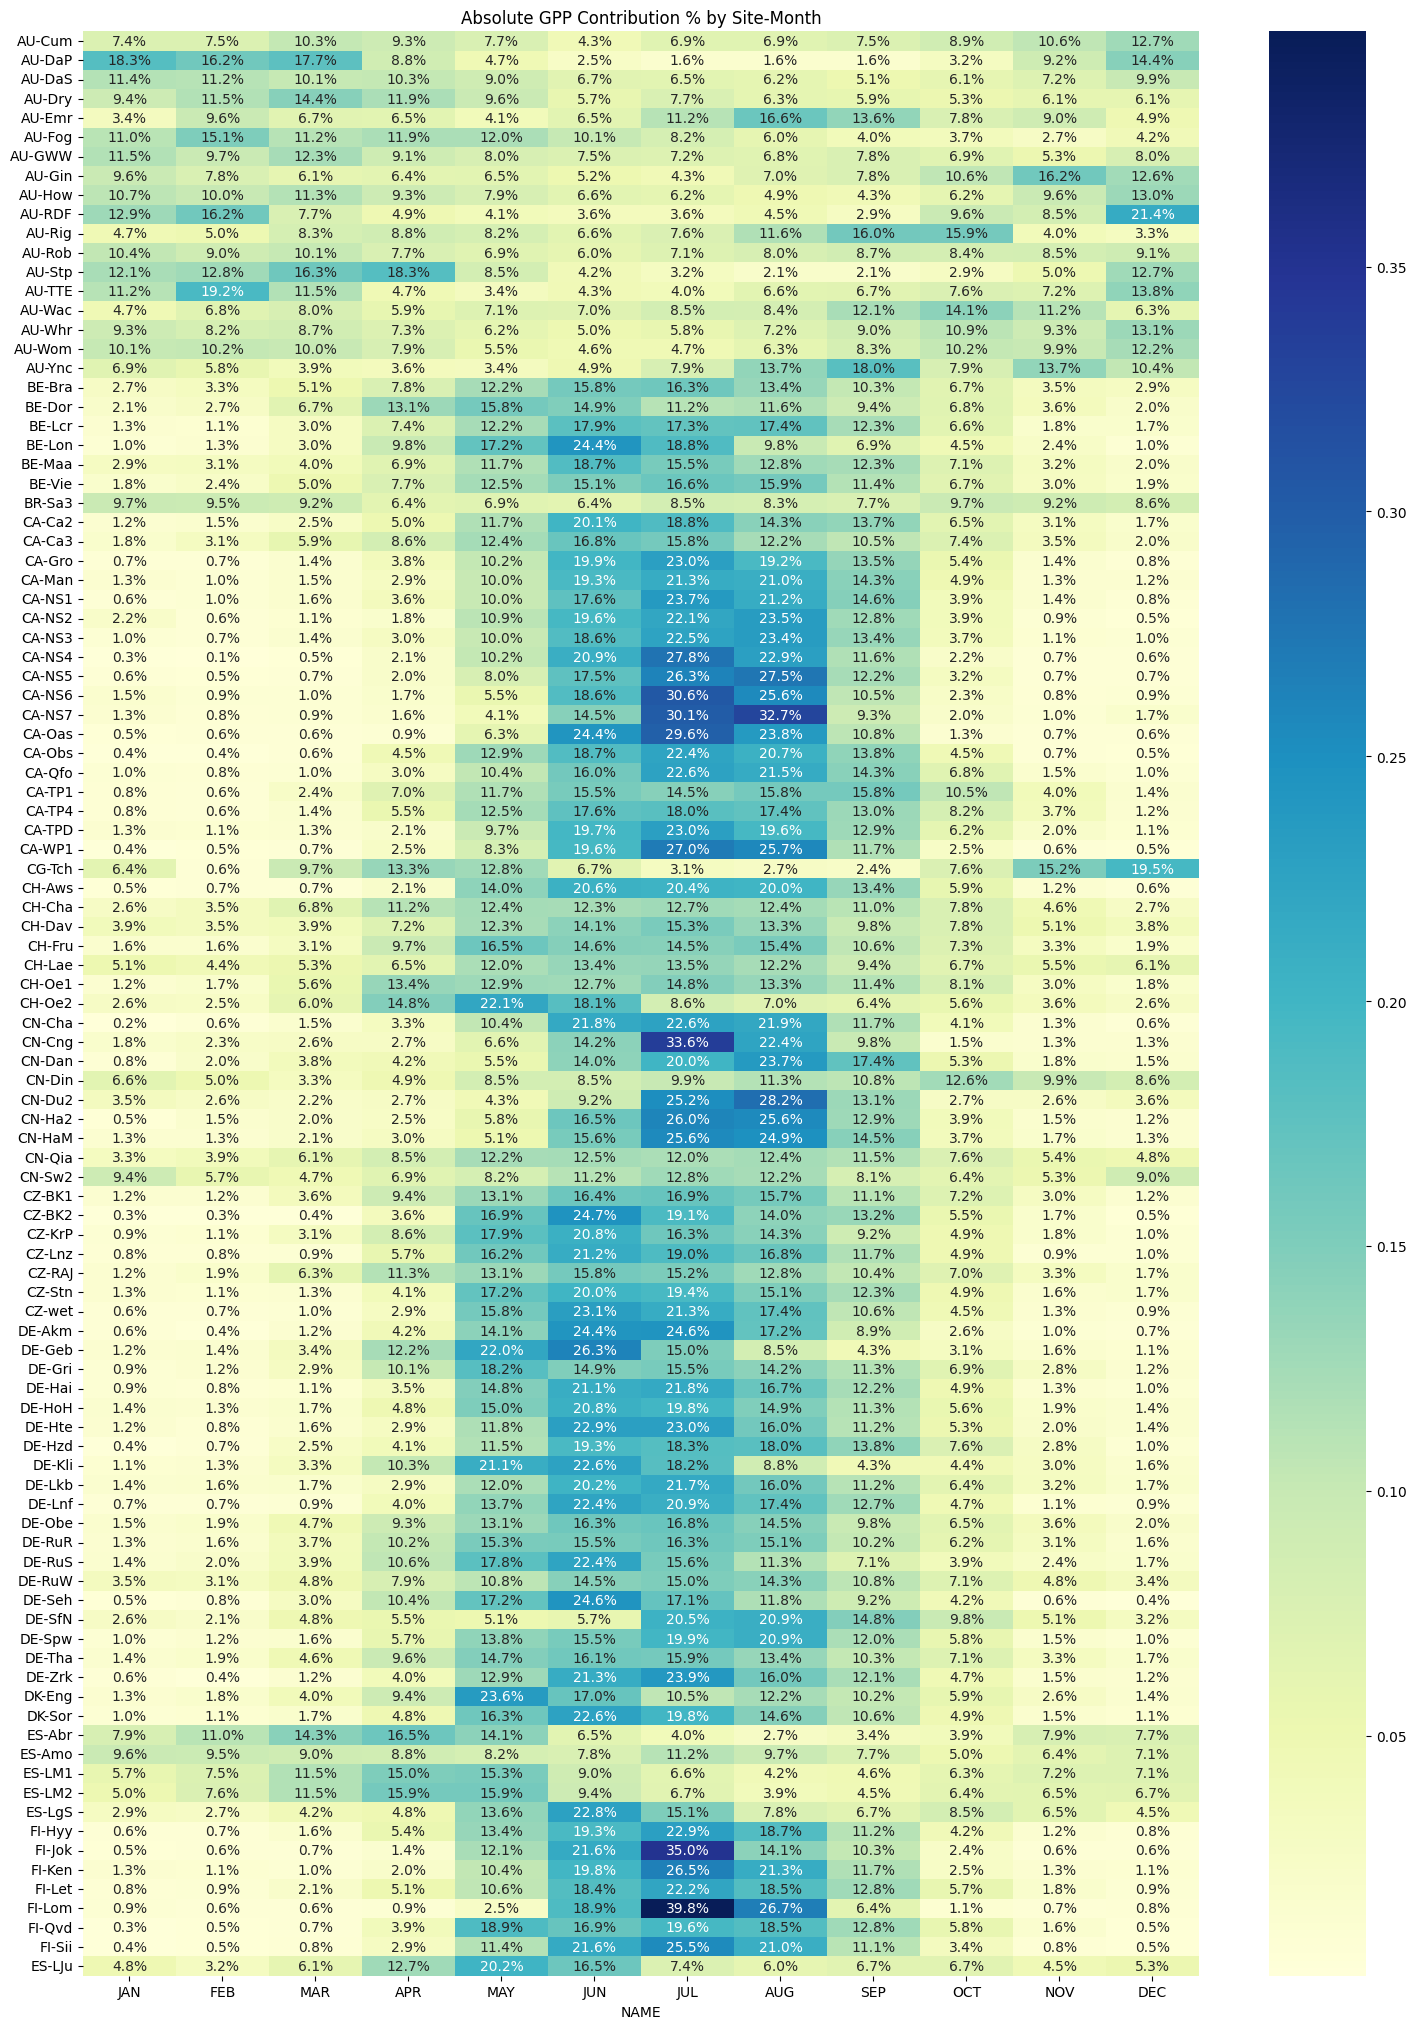

<Figure size 640x480 with 0 Axes>

In [14]:
# Heatmap for Month % Contribution
heat_df = build_heatmap(df=global_sites, timescale = 'MONTH', feat_str="M_%")

# Visualize monthly distributions
plt.figure(figsize=(18, len(global_sites)/4))
plt.title('Absolute GPP Contribution % by Site-Month')
sns.heatmap(heat_df, annot=True, fmt=".1%", cmap="YlGnBu")
plt.show()

# Save out
plt.savefig(f'{eda_img}/heatmap_monthly_gpp_contribution.png')

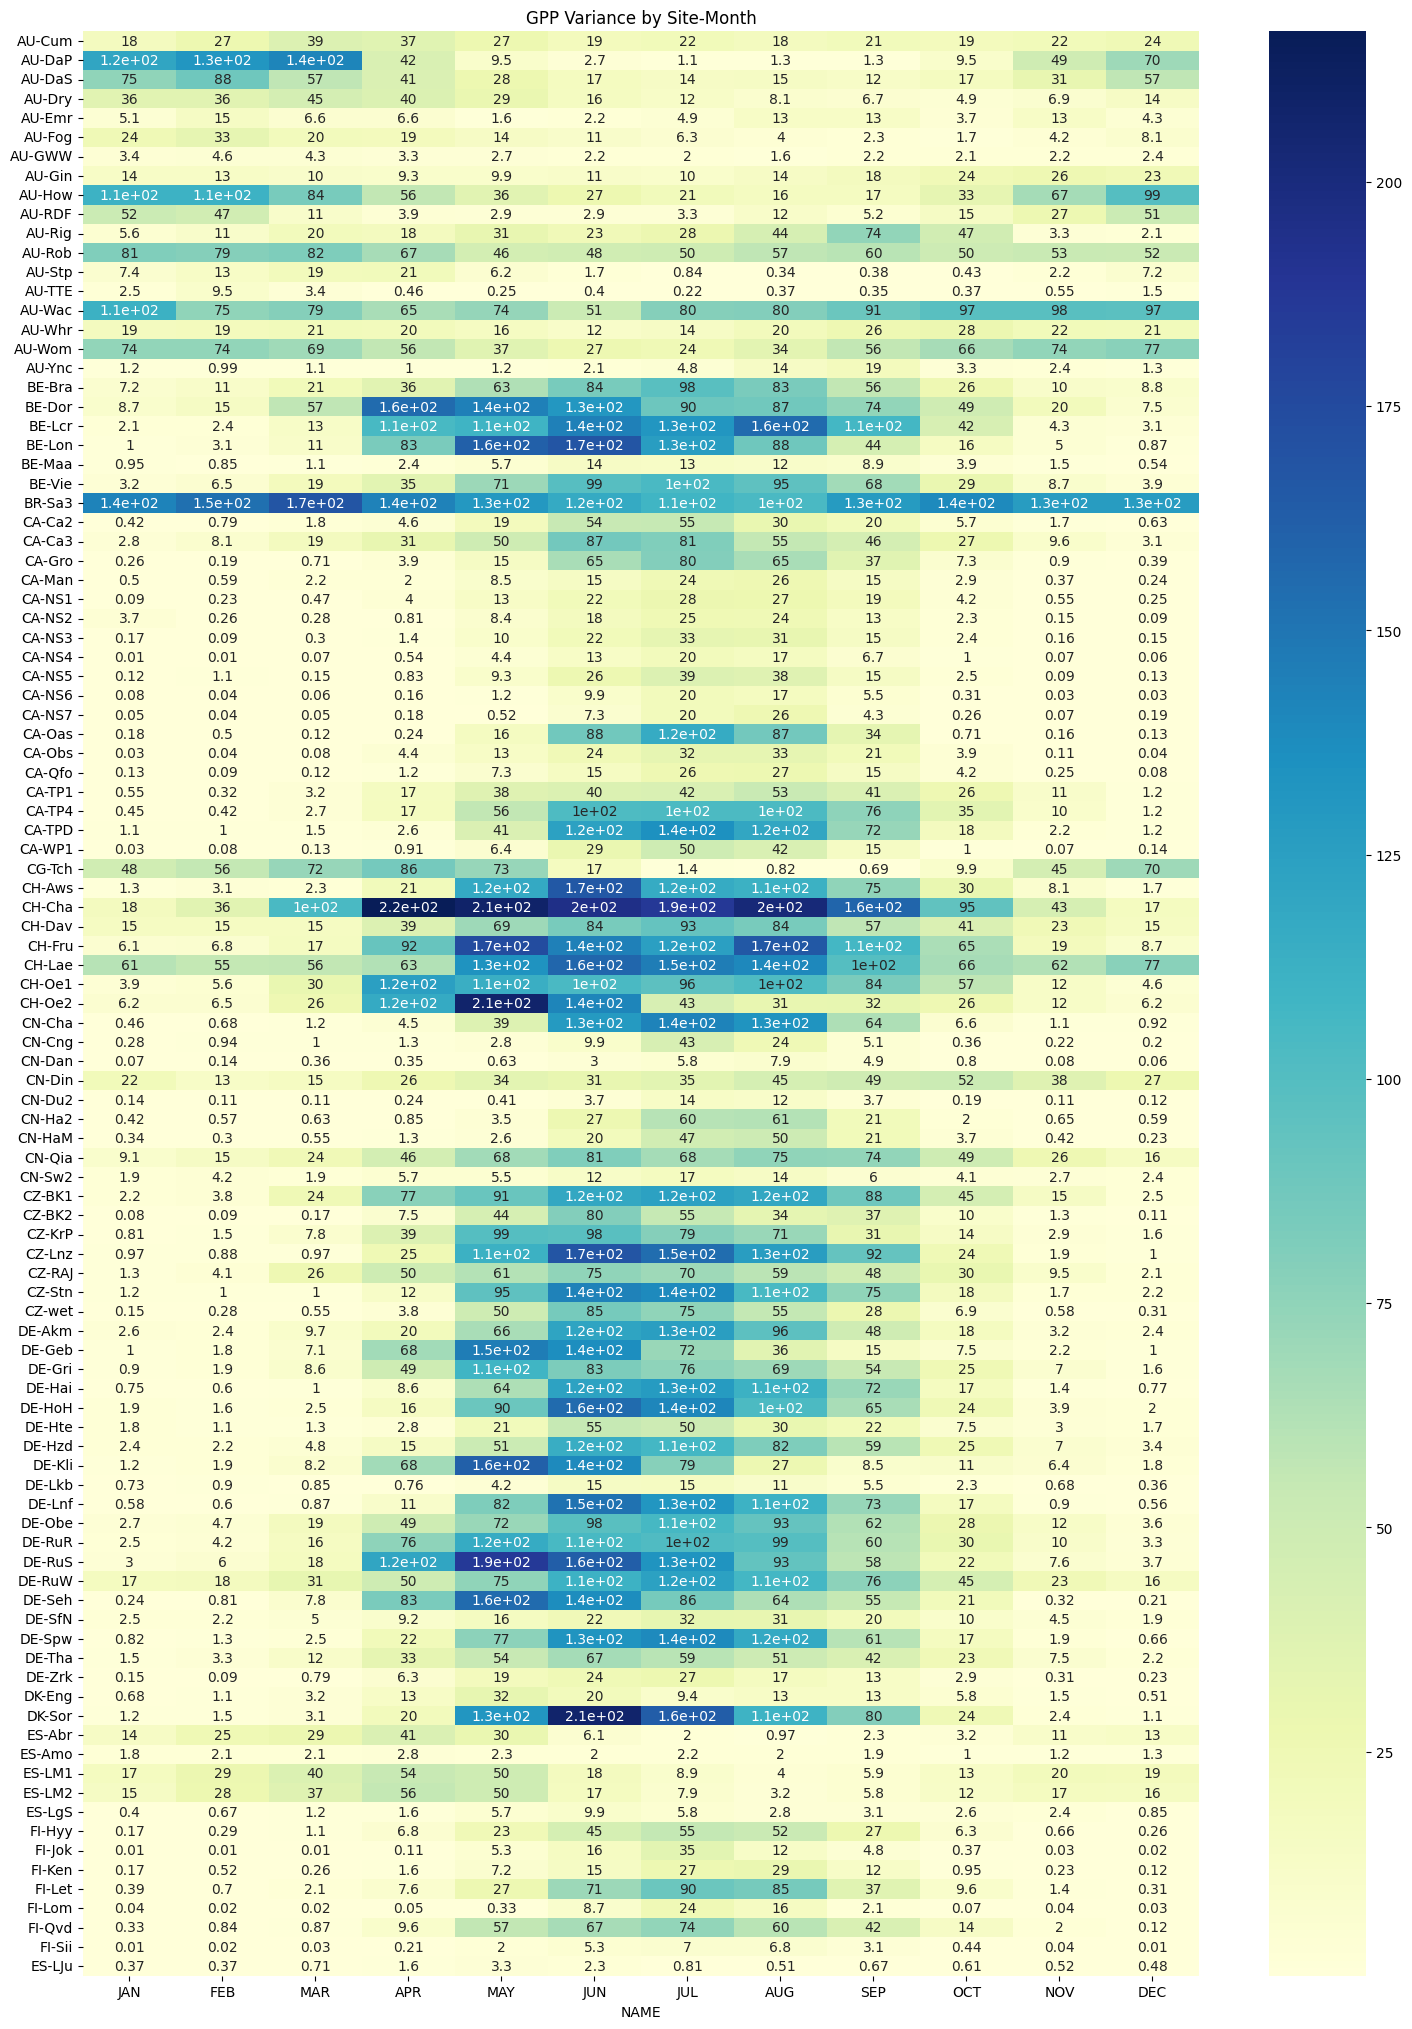

<Figure size 640x480 with 0 Axes>

In [15]:
# Heatmap for Month VAR
heat_df = build_heatmap(df=global_sites, timescale = 'MONTH', feat_str="M_VAR")

# Visualize monthly distributions
plt.figure(figsize=(18, len(global_sites)/4))
plt.title('GPP Variance by Site-Month')
sns.heatmap(heat_df, annot=True, cmap="YlGnBu")
plt.show()

# Save out
plt.savefig(f'{eda_img}/heatmap_monthly_gpp_variance.png')

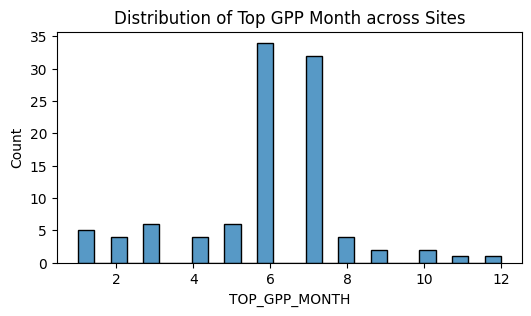

In [18]:
## Get distribution of top months
plt.figure(figsize=(6, 3))
plt.title('Distribution of Top GPP Month across Sites')
sns.histplot(global_sites['TOP_GPP_MONTH'])
plt.show()